# TM10007 Assignment: ADNI

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

ERROR! Session/line number was not unique in database. History logging moved to new session 61


# Import necessary functions/packages

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import interp
from scipy.stats import randint

# Classifiers
from sklearn import model_selection
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.fixes import loguniform
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Statistics
from statistics import mean

# Some functions we will use 

In [0]:
def removezeros(X):
  '''
  Remove features with only zero's as values
  '''
  X_nozeros = X.loc[:, (X != 0).any(axis=0)]
  return X_nozeros

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Data loading and preprocessing

In [0]:
# Data loading functions
from adni.load_data import load_data 
data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

""" 
kan dit weg?
#data_missing = data.isnull()
#print(data_missing.index[data_missing == True])
"""

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label
y = data['label']

# Split data in train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

# Remove features with only zero's as values
X_train_df = removezeros(X_train)
X_test_df = removezeros(X_test)
print(f'The number of samples: {len(X_train_df.index)}') # kan dit weg?
print(f'The number of features after removing zero-features: {len(X_train_df.columns)}')

# Get values of of the features
X_train = X_train_df.values
X_test = X_test_df.values

# Check if there are NaN's
x_nan = np.isnan(X_train)
print(f'The number of found NaN is: {np.sum(x_nan)}')
""" moeten we dit eigenlijk ook niet doen voor de test?"""

"""
kan dit weg?
#x_zero = np.where(X_train == 0)[0]
#print(f'The number of found zeros is: {len(x_zero)}')
"""

# Binarize the labels
y_train_bin = preprocessing.label_binarize(y_train,['AD','CN'])
y_train_bin = [i[0] for i in y_train_bin]
y_test_bin = preprocessing.label_binarize(y_test,['AD','CN'])
y_test_bin = [i[0] for i in y_test_bin]
y_bin = preprocessing.label_binarize(y,['AD','CN'])
y_bin = [i[0] for i in y_bin]

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of samples: 684
The number of features after removing zero-features: 263
The number of found NaN is: 0


# Feature scaling and selection


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.24738657495329, tolerance: 0.016363011695906433
  positive)


Selected 132 from 263 features with L1 method.


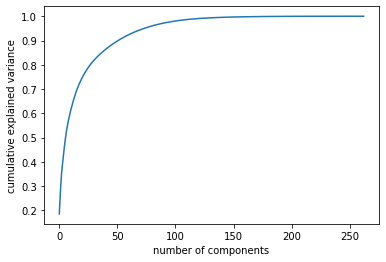

In [0]:
# Scaling of features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection - L1 method
selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), random_state=42), threshold='median')
selector.fit(X_train_scaled, y_train_bin)
n_original = X_train_scaled.shape[1]
X_train_test = selector.transform(X_train_scaled)
n_selected = X_train_test.shape[1]
print(f"Selected {n_selected} from {n_original} features with L1 method.")

# PCA
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Feature selection - PCA
pca = PCA(n_components=132)
pca = pca.fit(X_train_scaled)
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

# SVM classifier
Hyperparameter optimization of SVM

In [0]:
 # Define hyperparameters for SVM 
SVM_param = {'C': loguniform(1e0, 1e3), 
              'gamma': loguniform(1e-4, 1e0), 
              'kernel': ['rbf','poly', 'linear']}  

# Perform randomized search with cross-validation for hyperparameter optimization
grid = RandomizedSearchCV(SVC(probability=True), SVM_param, n_iter=10, refit = True, verbose = 3, random_state=42) 
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.781, total=   4.5s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.796, total=   6.8s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.818, total=   8.6s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.803, total=   8.7s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.728, total=   3.4s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.803, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.774, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]  C=218.3096839052459, gamma=0.02440060709081752, kernel=poly, score=0.774, total=   0.3s
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
[CV]

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


The best classifier is:  SVC(C=4.335281794951563, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0005337032762603955, kernel='rbf', max_iter=-1, probability=True,
    random_state=None, shrinking=True, tol=0.001, verbose=False)


ROC of SVM for train- and test-set

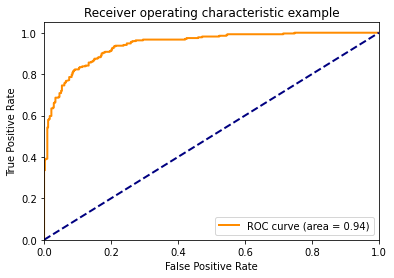

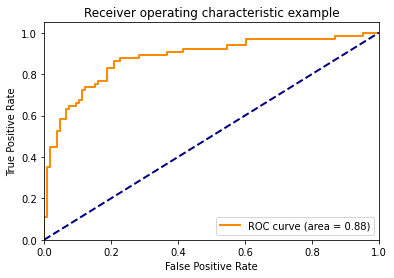

In [0]:
# Determine scores for train and test set
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)

# Plot ROC curve for train and test set
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

Calculate metrics of SVM with cross-validation

In [0]:
# Define the scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy','roc_auc']

# Calculate the scores with cross-validation
scores = cross_validate(grid.best_estimator_, x.values, y_bin, scoring=scoring, cv=20)

# Calculate the means of the score
mean_accuracy = mean(scores['test_accuracy'])
mean_precision = mean(scores['test_precision'])
mean_f1 = mean(scores['test_f1'])
mean_roc_auc = mean(scores['test_roc_auc'])
mean_recall = mean(scores['test_recall'])
print(f'mean accuracy is {mean_accuracy}')
print(f'mean precision is {mean_precision}')
print(f'mean f1 is {mean_f1}')
print(f'mean roc_auc is {mean_roc_auc}')
print(f'mean recall is {mean_recall}')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

mean accuracy is 0.6070598006644518
mean precision is 0.0
mean f1 is 0.0
mean roc_auc is 0.5
mean recall is 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# kNN classifier
Hyperparameter optimization of kNN

In [0]:
# Define hyperparameters for kNN
kNN_parameters = {'n_neighbors': list(range(1,101)), 
                   'weights':  ['uniform', 'distance'],
                   'metric': ['euclidean', 'manhattan']}

# Perform randomized search with cross-validation for hyperparameter optimization
grid = RandomizedSearchCV(KNeighborsClassifier(), kNN_parameters, refit = True, n_iter=10, random_state=42, verbose = 3)  
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.766, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.774, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.766, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.774, total=   0.0s
[CV] weights=distance, n_neighbors=5, metric=manhattan ...............
[CV]  weights=distance, n_neighbors=5, metric=manhattan, score=0.765, total=   0.0s
[CV] weights=uniform, n_neighbors=41, metric=manhattan ...............
[CV]  weights=uniform, n_neighbors=41, metric=manhattan, score=0.796, total=   0.0s
[CV] weig

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.7s finished


ROC of kNN for train- and test-set

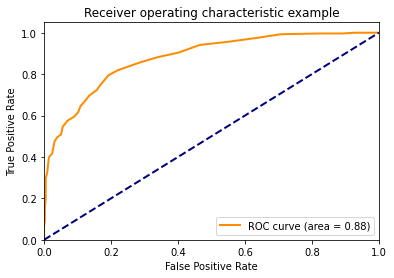

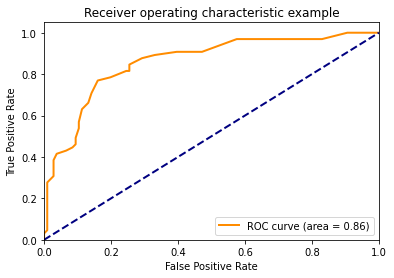

In [0]:
# Determine scores for train and test set
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)

# Plot ROC curve for train and test set
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

Calculate metrics of kNN with cross-validation

In [0]:
# Define the scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy','roc_auc']

# Calculate the scores with cross-validation
scores = cross_validate(grid.best_estimator_, x.values, y_bin, scoring=scoring, cv=20)

# Calculate the means of the score
mean_accuracy = mean(scores['test_accuracy'])
mean_precision = mean(scores['test_precision'])
mean_f1 = mean(scores['test_f1'])
mean_roc_auc = mean(scores['test_roc_auc'])
mean_recall = mean(scores['test_recall'])
print(f'mean accuracy is {mean_accuracy}')
print(f'mean precision is {mean_precision}')
print(f'mean f1 is {mean_f1}')
print(f'mean roc_auc is {mean_roc_auc}')
print(f'mean recall is {mean_recall}')

mean accuracy is 0.6738648947951273
mean precision is 0.6138448316389493
mean f1 is 0.5247059945523516
mean roc_auc is 0.7165398755656108
mean recall is 0.4713235294117647


# RF classifier
Hyperparameter optimization of RF

In [0]:
# Define hyperparameters for RF
forest_parameters = {'n_estimators': list(range(50,301)), 
                   'criterion':  ['gini', 'entropy'],
                   'max_depth': [4, 5, 6, 7, 8, 9, 10],
                   'max_features': ['auto','sqrt','log2']}

# Perform randomized search with cross-validation for hyperparameter optimization
grid = RandomizedSearchCV(RandomForestClassifier(), forest_parameters, refit = True, n_iter=10, random_state=42, verbose = 3)  
grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.796, total=   1.8s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.737, total=   1.8s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.774, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.803, total=   1.7s
[CV] n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy 
[CV]  n_estimators=292, max_features=sqrt, max_depth=6, criterion=entropy, score=0.713, total=   1.7s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.796, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.715, total=   0.5s
[CV] n_estimators=157, max_features=auto, max_depth=5, criterion=gini 
[CV]  n_estimators=157, max_features=auto, max_depth=5, criterion=gini, score=0.730, total=   0.5s
[CV] n_estimators=157, max_features=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   46.0s finished


The best classifier is:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=292,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


ROC of RF for train- and test-set

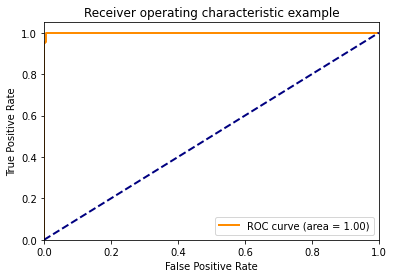

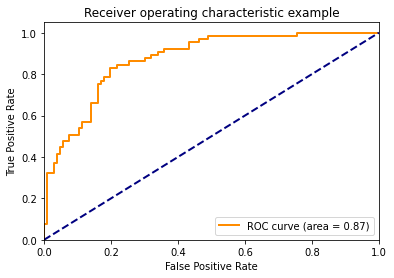

In [0]:
# Determine scores for train and test set
score_train = grid.best_estimator_.predict_proba(X_train)
score_test = grid.best_estimator_.predict_proba(X_test)

# Plot ROC curve for train and test set
plot_roc_curve(score_train, y_train_bin)
plot_roc_curve(score_test, y_test_bin)

Calculate metrics of RF with cross-validation

In [0]:
# Define the scoring metrics
scoring = ['precision', 'recall', 'f1', 'accuracy','roc_auc']

# Calculate the scores with cross-validation
scores = cross_validate(grid.best_estimator_, x.values, y_bin, scoring=scoring, cv=20)

# Calculate the means of the score
mean_accuracy = mean(scores['test_accuracy'])
mean_precision = mean(scores['test_precision'])
mean_f1 = mean(scores['test_f1'])
mean_roc_auc = mean(scores['test_roc_auc'])
mean_recall = mean(scores['test_recall'])
print(f'mean accuracy is {mean_accuracy}')
print(f'mean precision is {mean_precision}')
print(f'mean f1 is {mean_f1}')
print(f'mean roc_auc is {mean_roc_auc}')
print(f'mean recall is {mean_recall}')

mean accuracy is 0.8024086378737542
mean precision is 0.7673836032388665
mean f1 is 0.7389148309659254
mean roc_auc is 0.8792825226244344
mean recall is 0.7180147058823529
